In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using FenrirForNeuro, ModelingToolkit, OrdinaryDiffEq
using FileIO

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function simulate(prob, p, proj)
    tₛ, tₑ = prob.tspan
    sol = solve(
        remake(prob, p=p),
        RadauIIA5(),
        abstol=1e-14,
        reltol=1e-14,
        dense=false,
    )
    t_obs = sol.t[1:end]
    u_obs = vcat([(proj * u) for u in sol.u]...)
    return t_obs, u_obs
end

function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)

pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end

where_converged (generic function with 2 methods)

In [5]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.7 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [6]:
@parameters gNa gK
θ = [gNa => 25, gK => 7]
prob_prior, prob = get_SinglecompartmentHH(θ)

proj = [1 0 0 0]
observation = generate_data(prob, proj, 1e-1, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100.0], u = [[-69.79382692968001], [-69.97410123605063], [-70.51777278830059], [-69.89384502853306], [-69.47777302967086], [-70.22844631529503], [-70.01060470334174], [-69.81975480987798], [-70.22597210926504], [-69.76698027054191]  …  [-65.71153482747367], [-65.49160611903538], [-65.41642922368159], [-66.22424297995893], [-65.0051392657134], [-65.92545044845096], [-65.18571492656254], [-66.01339007390142], [-65.29839532530919], [-65.67941284339861]])

In [7]:
PATH = RESULTS_PATH * "hh/2p/simple/fenrir/tempered_diff/"
opt_fnames = readdir.(PATH)

trajectories = import_csvs(PATH, opt_fnames, [pkeys(θ)..., :κ², :loss, :T])

PATH = RESULTS_PATH * "hh/2p/simple/fenrir/loss_surface"
loss_surface_fnames = filter(x -> !occursin("grad", x), readdir.(PATH))
sort_fnames(fnames) = fnames[sortperm([parse(Int64, split(split(fname, "-")[end-1], "_")[end]) for fname in fnames])]
loss_surface_fnames = sort_fnames(loss_surface_fnames)

loss_surface_sections = import_csvs(PATH, loss_surface_fnames)

tempering_schedule = reverse([10.0^x for x in 0:20])
header = ["gNa", "gK", [@sprintf("κ²=%1.e", κ²) for κ² in tempering_schedule]...]

loss_surface = vcat(loss_surface_sections...)
rename!(loss_surface, header)

lb, ub = get_prior_bounds(prob_prior)

((gNa = 0.5, gK = 0.0001), (gNa = 80.0, gK = 15.0))

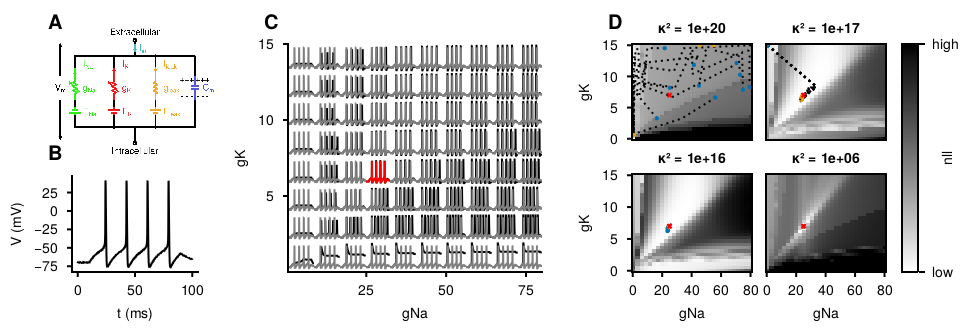

In [9]:
# import png
schematic_path = FIGURES_PATH * "hh_schematic.png"
hh_schematic = load(schematic_path)

f = Figure(size=(FULL_WIDTH, HEIGHT), figure_padding=(5,10,5,5))
fa = f[1, 1] = GridLayout()
fb = f[1, 2] = GridLayout()
fc = f[1, 3] = GridLayout()


ax1 = Axis(fa[1, 1]; PLOT_DEFAULTS..., aspect=DataAspect(), alignmode=Outside(-10))
image!(ax1, rotr90(hh_schematic)) # probably want to supply x & y scale of data here
hidedecorations!(ax1)
hidespines!(ax1)

ax2 = Axis(fa[2, 1], xlabel="t (ms)", ylabel="V (mV)"; PLOT_DEFAULTS...)
lines!(ax2, observation.t, vcat(observation.u...), color=:black, linewidth=1)
hidedecorations!(ax2, grid=true, label=false, ticklabels=false, ticks=false)
hidespines!(ax2, :t, :r)
rowsize!(fa, 1, Relative(0.5))

num_gNa, num_gK = 10, 8
# num_gNa, num_gK = 6, 5
ps₀ = reshape(get_prior_lattice((num_gNa, num_gK), prob_prior, LinRange), num_gNa, num_gK, :)
unsqueezed_θ_true = cat([fill(p, size(ps₀)[1:2]) for p in pvalues(θ)]..., dims=3)
min_idx = Tuple(argmin(sqrt.(sum(abs2.(ps₀ .- unsqueezed_θ_true), dims=3))))[1:2]

axes = []
for x in 1:num_gNa
    for y in 1:num_gK
        color = (x, y) == min_idx ? :red : :grey
        ax = Axis(fb[num_gK-y, x]; PLOT_DEFAULTS...)
        t, u = simulate(prob, ps₀[x, y, :], proj)
        lines!(ax, t, u, color=:black, linewidth=1)
        lines!(ax, observation.t, vcat(observation.u...), color=color, linewidth=1)
        hidexdecorations!(ax, label=y != 1 ? true : false)
        hideydecorations!(ax, label=x != 1 ? true : false)
        hidespines!(ax, :l, :t, :r, :b)
        xlims!(ax, (-1, 101))
        push!(axes, ax)
    end
end
linkyaxes!(axes...)
linkxaxes!(axes...)

ax3 = Axis(f[1, 2], xlabel="gNa", ylabel="gK"; PLOT_DEFAULTS...)
scatter!(ax3, [0], [0], markersize=0)
xlims!(ax3, (lb[1], ub[1]))
ylims!(ax3, (lb[2], ub[2]))
hidespines!(ax3, :r, :t)
hidedecorations!(ax3, grid=true, label=false, ticklabels=false, ticks=false)

rowgap!(fb, 0)
colgap!(fb, 0)


subset = [1, 4, 5, 15]
nll = reshape(Array(loss_surface[:, 3:end]), (30, 30, 21))
gNa_range = sort(unique(Array(loss_surface[:, 1])))
gK_range = sort(unique(Array(loss_surface[:, 2])))

nll_subset = nll[:, :, subset]
for (i, κ²) in enumerate(tempering_schedule[subset])
    title = @sprintf("κ² = %1.e", κ²)
    ax_c = Axis(fc[Int64(floor((i - 1) / 2))+1, ((i-1)%2)], xlabel="gNa", ylabel="gK", title=title; PLOT_DEFAULTS...)
    xlims!(ax_c, (-1 + lb[1], ub[1] + 1))
    ylims!(ax_c, (-0.2 + lb[2], ub[2] + 0.2))

    # prepare data
    t_at_κ² = [t[log.(t[!, :κ²]).==log.(κ²), :] for t in trajectories]

    # plot
    norm_nll = (nll_subset[:, :, i])
    # normalize 
    norm_nll = (norm_nll .- minimum(norm_nll)) ./ (maximum(norm_nll) - minimum(norm_nll))
    heatmap!(ax_c, gNa_range, gK_range, norm_nll, colormap=reverse(cgrad(:greys)), colorrange=(0, i in [1, 4] ? 0.2 : 1), highclip=:black)
    for t in t_at_κ²[1:10]
        if size(t)[1] > 0
            lines!(ax_c, t[!, pkeys(θ)[1]], t[!, pkeys(θ)[2]], linewidth=1, color=:black, linestyle=:dot)
            scatter!(ax_c, t[1, pkeys(θ)[1]], t[1, pkeys(θ)[2]], color=Makie.wong_colors()[1], markersize=3)
            scatter!(ax_c, t[end, pkeys(θ)[1]], t[end, pkeys(θ)[2]], color=Makie.wong_colors()[2], markersize=3)
        end
    end

    scatter!(ax_c, pvalues(θ)..., color=:red, markersize=4, marker=:x)

    # fmt
    hidey = ((i - 1) % 2) != 0
    hidex = Int64(floor((i - 1) / 2)) + 1 != 2
    hidexdecorations!(ax_c, label=hidex, ticks=hidex, ticklabels=hidex)
    hideydecorations!(ax_c, label=hidey, ticks=hidey, ticklabels=hidey)
end

cbar = Colorbar(f[1, 4], label="nll", ticklabelsize=7, limits=(0, 1), labelsize=7, ticks=([0, 1], ["low", "high"]), size=8, ticksize=3, labelpadding=-10, colormap=reverse(cgrad(:greys)))
colgap!(f.layout, 3, Relative(0.02))

colgap!(fc, 7)
rowgap!(fc, 5)

Label(f.layout[1, 1, TopLeft()], "A", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 1, Left()], "B", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 2, TopLeft()], "C", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 3, TopLeft()], "D", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)

colsize!(f.layout, 1, Auto(0.5))

f

In [10]:
save(joinpath(FIGURES_PATH, "figure4.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
